# Exploring the forcing used for the f6 forecast and c5 control runs
Note that the longnames of the f6 forecasts follow c5-d60-pX-f6-INIT (where INIT is the initialisation date) indicating that c5 is the relevant control run for these forecasts.

All (resonable sized) files used in this notebook are copied in the /resources directory in this repo.

In [1]:
import glob
import numpy as np
import xarray as xr
from distributed import Client
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster

import warnings
warnings.filterwarnings("ignore")

### Cluster only needed for examining actual control and forecast data, not for looking at forcing files

In [4]:
walltime = '01:00:00'
cores = 12
memory = '24GB'

cluster = PBSCluster(processes=1,
                     walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P ux06',
                                '-l jobfs=100GB',
                                '-l storage=gdata/xv83+gdata/v14+gdata/v19+scratch/v14'],
                     local_directory='$PBS_JOBFS',
                     header_skip=['select'])

In [5]:
cluster.scale(jobs=6)
client = Client(cluster)
client

Client Scheduler: tcp://10.6.44.72:42303 Dashboard: http://10.6.44.72:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
def read_gblannualdata(file_name):
    with open(file_name, 'r') as data:
        next(data)
        x = []
        y = []
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            y.append(float(p[1]))

    return xr.DataArray(y, dims=('year'), coords={'year': x})

# Control run 5

Matt Chamberlain's readme (`./resources/g.data.v19.mtc599.ao_am2.readme.txt`) identifies his run /aug18a as c5:

   > aug18a/ \
(control-5 => control-4 with deep restoring)
clone of the control may18b/ but with deep restoring.
Hiccup with CFC fixed at start of year 0244; CFC tracer field had been reset at year 0200, however the atmospheric boundary condition was not set to the century 0200 to 0299.
At 0244, reset tracer fields to zero and fix boundary condition.
(Control 5)

We can get an idea for how this control run was forced by looking at select lines in the namelist (`./resources/g.data.v19.mtc599.ao_am2.aug18a.input.nml`):

That is, 1990 forcing is used for a variety of aerosol, ozone, solar, and radiative gas forcings. No volcanic forcing is applied

## What do these forcing files look like?

### aerosol.climatology.nc 
\> climatologies of aerosol concentrations for each decade \
\> max decade 2010

In [4]:
path = '/g/data/v19/mtc599/ao_am2/aug18a/'

f = xr.open_dataset(f'{path}INPUT/aerosol.climatology.nc')

In [5]:
f

<xarray.Dataset>
Dimensions:           (lat: 80, latb: 81, lon: 96, lonb: 97, sigma_full: 14, sigma_half: 15, time: 204)
Coordinates:
  * lon               (lon) float32 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
  * lonb              (lonb) float32 -1.875 1.875 5.625 ... 350.6 354.4 358.1
  * lat               (lat) float32 -88.29 -86.07 -83.84 ... 83.84 86.07 88.29
  * latb              (latb) float32 -90.0 -87.18 -84.96 ... 84.96 87.18 90.0
  * sigma_full        (sigma_full) float32 0.015 0.05035 ... 0.9786 0.9966
  * sigma_half        (sigma_half) float32 0.0 0.03 0.0707 ... 0.964 0.9933 1.0
  * time              (time) object 1859-01-16 00:00:00 ... 2010-12-16 00:00:00
Data variables: (12/21)
    so4_anthro        (time, sigma_full, lat, lon) float32 ...
    so4_natural       (time, sigma_full, lat, lon) float32 ...
    organic_carbon    (time, sigma_full, lat, lon) float32 ...
    black_carbon      (time, sigma_full, lat, lon) float32 ...
    sea_salt          (time, sigma_full, lat, lon) float32 ...
    anthro_dust_0.1   (time, sigma_full, lat, lon) float32 ...
    ...                ...
    natural_dust_0.4  (time, sigma_full, lat, lon) float32 ...
    natural_dust_0.8  (time, sigma_full, lat, lon) float32 ...
    natural_dust_1.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_2.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_4.0  (time, sigma_full, lat, lon) float32 ...
    natural_dust_8.0  (time, sigma_full, lat, lon) float32 ...
Attributes:
    title:        Monthly mean aerosol distributions for use in FMS AM models
    authors:      Stuart Freidenreich (smf@gfdl.noaa.gov): Compilation of dat...
    institution:  GFDL/NOAA
    history:      Tue Aug 17 15:26:36 2004: ncks -v time -A /net/lwh/fms/aero...

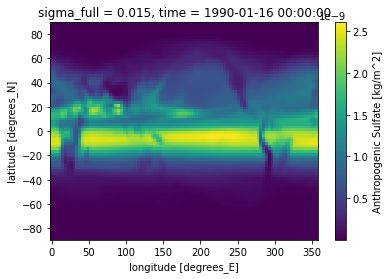

In [6]:
f['so4_anthro'].sel(time='1990-01').isel(sigma_full=0).plot()

### o3.climatology.nc
\> monthly values of ozone mass mixing ratio (decadal frequency prior to 1980) \
\> max year 2004

In [7]:
f = xr.open_dataset(f'{path}INPUT/o3.climatology.nc')

In [8]:
f['ozone']

<xarray.DataArray 'ozone' (time: 468, pfull: 40, lat: 60, lon: 100)>
[112320000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 1.8 5.4 9.0 12.6 16.2 ... 347.4 351.0 354.6 358.2
  * lat      (lat) float32 -88.5 -85.5 -82.5 -79.5 -76.5 ... 79.5 82.5 85.5 88.5
  * pfull    (pfull) float32 0.00957 0.03083 0.06967 ... 922.2 972.9 1.004e+03
  * time     (time) object 1859-01-16 00:00:00 ... 2004-12-16 00:00:00
Attributes:
    units:      kg/kg
    long_name:  ozone mass mixing ratio

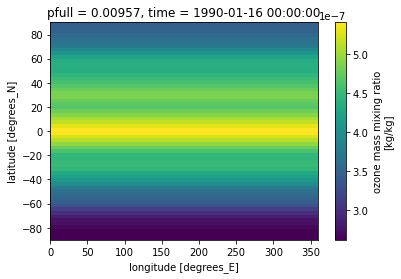

In [9]:
f['ozone'].sel(time='1990-01').isel(pfull=0).plot()

### radiative gases
It's not clear from the namelist what files are used for these forcings. I _think_ the model must use the following files from the /INPUT directory:
   > ch4_gblannualdata \
   co2_gblannualdata \
   f113_gblannualdata \
   f11_gblannualdata \
   f12_gblannualdata \
   f22_gblannualdata \
   n2o_gblannualdata

\> annual global-average timeseries \
\> max year 2004

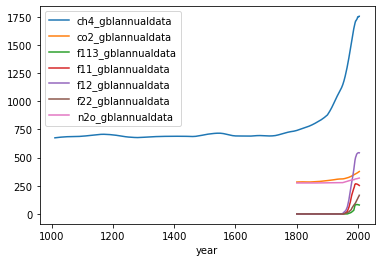

In [10]:
files = ['ch4_gblannualdata', 'co2_gblannualdata', 'f113_gblannualdata', 'f11_gblannualdata', 
         'f12_gblannualdata', 'f22_gblannualdata', 'n2o_gblannualdata']
for file in files:
    f = read_gblannualdata(f'{path}INPUT/{file}')
    f.plot()
plt.legend(files)

## So what does the c5 data look like?

### E.g. global average sst
Note, the format of the files changes in the year 0100 (`grid_xt_ocean`, `grid_yu_ocean`, `potrho`, `potrho_edges` are added as coordinates) and 0300 (many more variables added) and xarray struggles with automatically merging these periods. Do this manually.

In [11]:
files = sorted(glob.glob(f'{path}OUTPUT/ocean_month*.nc'))
kwargs = dict(
    concat_dim='time',
    chunks={'time': 48},
    compat='override',
    coords='minimal',
    data_vars='minimal',
    parallel=True)

om1 = xr.open_mfdataset(
    files[:99],
    **kwargs)

om2 = xr.open_mfdataset(
    files[99:299],
    **kwargs)

om3 = xr.open_mfdataset(
    files[299:],
    **kwargs)

In [16]:
%%time
depth = 1000
sst = xr.concat([
    om1['temp'].sel(st_ocean=depth, method='nearest'),
    om2['temp'].sel(st_ocean=depth, method='nearest'),
    om3['temp'].sel(st_ocean=depth, method='nearest')],
    dim='time')
area_t = om3['area_t']

sst_gbl = sst.weighted(area_t).mean(['xt_ocean','yt_ocean']).compute()

CPU times: user 8.84 s, sys: 393 ms, total: 9.23 s
Wall time: 35.5 s


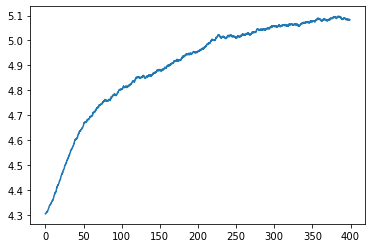

In [17]:
plt.plot(np.arange(len(sst_gbl)) / 12, sst_gbl)

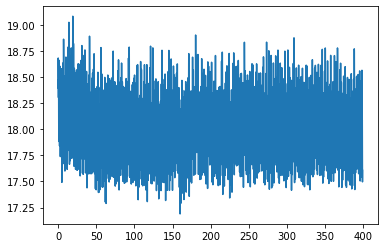

In [128]:
plt.plot(np.arange(len(sst_gbl)) / 12, sst_gbl)

**So, given the comment in the readme copied above, c5 provides 155 years (years 244-399) of apparently stable control run with 1990(s) forcing**

# Forecast 6

The relevant lines in the f6 namelist are as follows (`./resources/g.data.v14.ds0092.active_projects.cm-forecasts.ref.MODEL.input.in`):

where the following replacements are made before submission (see `./resources/g.data.v14.ds0092.active_projects.cm-forecasts.src.run_CAFE_forecasts.sh.in`):

 - Replace
   ```
       INPUT_AEROSOL_TIME -> "AYEAR, 1, 1, 0, 0, 0"
   ```
   where AYEAR is the middle year of the decade in which the forecast is initialised (e.g. AYEAR=2005 for any
   start date in the 2000s). If AYEAR is greater than 2015, then 2015 is used.
   
 - If the forecast is initialised after 2000 then replace,
   ```
       REPEAT_VOLCANO_YEAR -> "repeat_volcano_year=.true."
       VOLCANO_YEAR_USED -> "volcano_year_used = 2008,"
   ```
   otherwise these lines are commented out.
   
- If the forecast is initialised after 2004 then replace,
   ```
       BASIC_OZONE_TYPE -> "fixed_year"
       OZONE_DATASET_ENTRY -> "ozone_dataset_entry=2014, 1, 1, 0, 0, 0,"
       FILENAME -> "cm3_2014_o3.padded.nc"
   ```
   otherwise replace,
   ```
       BASIC_OZONE_TYPE -> "time_varying"
       FILENAME -> "CM3_CMIP6_1950-2014_O3.nc"
   ```
   and OZONE_DATASET_ENTRY is commented out.
   
As above, I'm only assuming that it's the `*_glbannualdata` files that specify the radiative gas forcing. There's also a separate part of the run scripts where the following is added to the field_table (`./resources/g.data.v14.ds0092.active_projects.cm-forecasts.ref.MODEL.field_table_bgc`):
- If the forecast is initialised after 2007 then,
   ```
       aco2_file = "INPUT/co2_obs.padded.nc"
   ```
   otherwise,
   ```
       aco2_file = "INPUT/co2_obs.nc"
   ```

I think these files are used by the bgc component of the model (confirm with Matt). Notably, `co2_obs.padded.nc` includes projected values into the future, but both files are identical in their overlapping period so the switch from co2_obs.nc to co2_obs.padded.nc seems to be redundant.

## What does this mean?

### Aerosols climatologies
Aerosol forcing climatologies are provided per decade. Forecasts initialised prior to 2020 are forced using the climatologies corresponding to the decade of their initialialisation (e.g. 2000s forcing climatologies for every forecast initialised in 2000-2009). Forecasts initialised in 2020 of later use the 2010s aerosol forcing climatologies.

**It's not clear to me why we only use aerosol.climatology.nc until 2010s here since the timeseries goes until the 2020s**

In [4]:
path = '/scratch/ux06/ds0092/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-19890501/mem001/'

In [5]:
f = xr.open_dataset(f'{path}INPUT/aerosol.climatology.nc')

In [6]:
f['so4'].time.values[-24:]

array([cftime.DatetimeJulian(2015, 1, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 2, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 3, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 4, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 5, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 6, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 7, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 8, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 9, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 10, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 11, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2015, 12, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2025, 1, 16, 0, 0, 0, 0, has_year_zero=False),
       cf

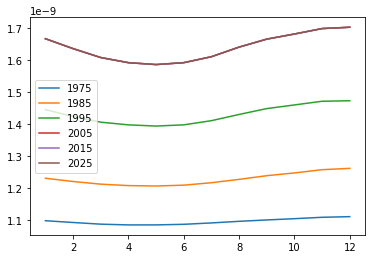

In [7]:
periods = range(1975,2030,10)
for p in periods:
    so4 = f['so4'].isel(sigma_full=0).sel(time=str(p)).mean(['lat','lon']) # Global average
    plt.plot(range(1,13), so4)  
plt.legend(periods)

**Oh, every entry beyond 2005 is identical to 2005...**

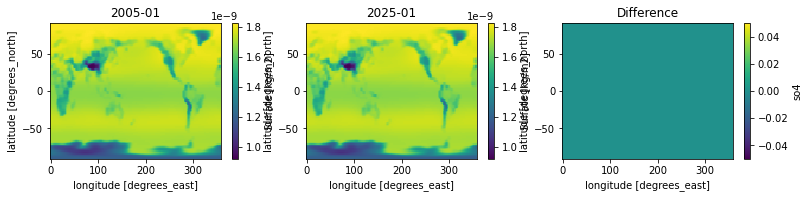

In [8]:
t1 = '2005-01'
t2 = '2025-01'
a = f['so4'].isel(sigma_full=0).sel(time=t1).squeeze()
b = f['so4'].isel(sigma_full=0).sel(time=t2).squeeze()

fig, ax = plt.subplots(1,3, figsize=(13,2.5))
a.plot(ax=ax[0])
ax[0].set_title(t1)
b.plot(ax=ax[1])
ax[1].set_title(t2)
(a-b).plot(ax=ax[2])
ax[2].set_title('Difference');

### Volcanic forcing
Time varying volcanic forcing is used for forecasts initialised prior to or during 2000, and 2008 volcanic forcing is used for those initialised after 2000. I find this framework strange for a couple of reasons:

 - Having the switch between time varying and fixed forcing based on _initialisation date_ means that the same calendar year can experience different forcing, depending on its lead time. For example, The lead 2 year forecast of 2002 (initialised 2000) will be forced with 2002 volcanic forcing, but the lead 1 forecast of 2002 (initialised 2001) will be forced with 2008 forcing. This makes the forecasts very difficult to interpret and, perhaps more importantly, baseline.

 - Are any issues introduced by suddenly changing to 2008 forcing in 2001? Presumably this is done because 2008 represents something like a "neutral" forcing year? I note the following (perhaps irrelevant) text from the CMIP5 docs (https://pcmdi.llnl.gov/mips/cmip5/docs/Taylor_CMIP5_design.pdf):
  > Care must be taken in accounting for volcanic eruptions that occurred prior to 1850 and also in the future because this can especially impact sea level changes, which respond on multi-century time-scales. If we completely neglect volcanoes prior and after the historical period, then we shall exaggerate their effect on the historical sea level record because during this period the average forcing will become negative (relative to the pre-industrial control). If we include a background volcanic aerosol forcing in the pre-industrial control run, then the same background aerosol should probably be included in the future runs, otherwise there would be a slight exaggeration in the warming (and in sea level increases) throughout the future runs, which would almost certainly be unrealistic. However, imposing a background volcanic aerosol instantaneously in year 2006 of the “future” runs (see Table 1) would also be unrealistic because there were no  major volcanic eruptions in 2006. It is recommended that either volcanic aerosols should be omitted entirely from both the control and future runs, or, alternatively, the same background aerosol should be prescribed in both runs.

In [9]:
f = xr.open_dataset(f'{path}INPUT/extsw_data.nc')

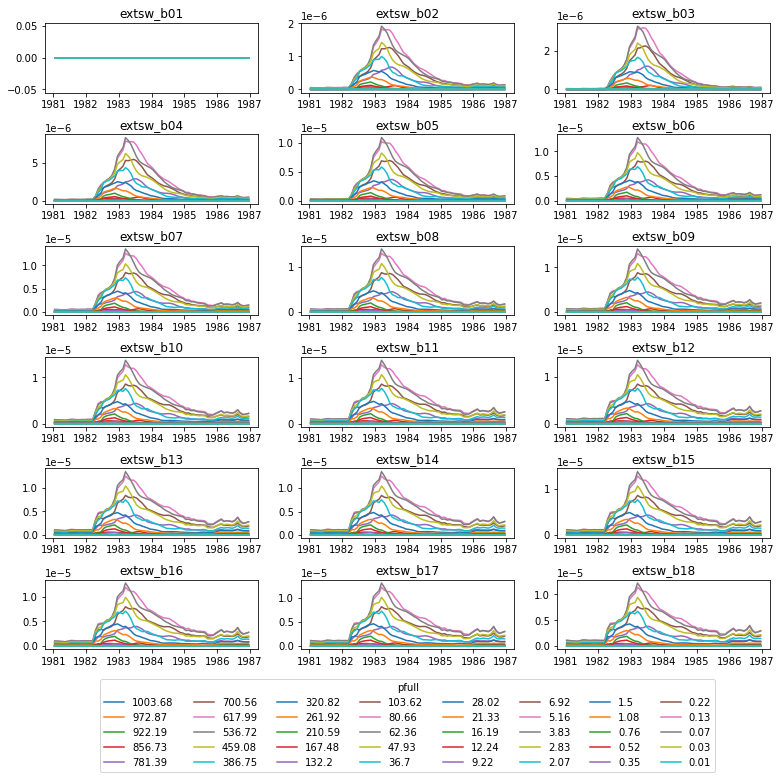

In [11]:
period = slice('1981', '1986')
fig, ax = plt.subplots(6,3, figsize=(13,15))

for a, v in zip(ax.flatten(), f):
    lat_mean = f[v].sel(time=period).mean('lat')
    for lev in lat_mean.pfull.values:
        a.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
                lat_mean.sel(pfull=lev))
    a.set_title(v)
    
fig.subplots_adjust(bottom=0.3, hspace=0.6, wspace=0.2)

ax.flatten()[-2].legend(lat_mean.pfull.values, 
                        title='pfull', loc='upper center', 
                        bbox_to_anchor=(0.5, -0.35), ncol=8);

In [12]:
f = xr.open_dataset(f'{path}INPUT/omgsw_data.nc')

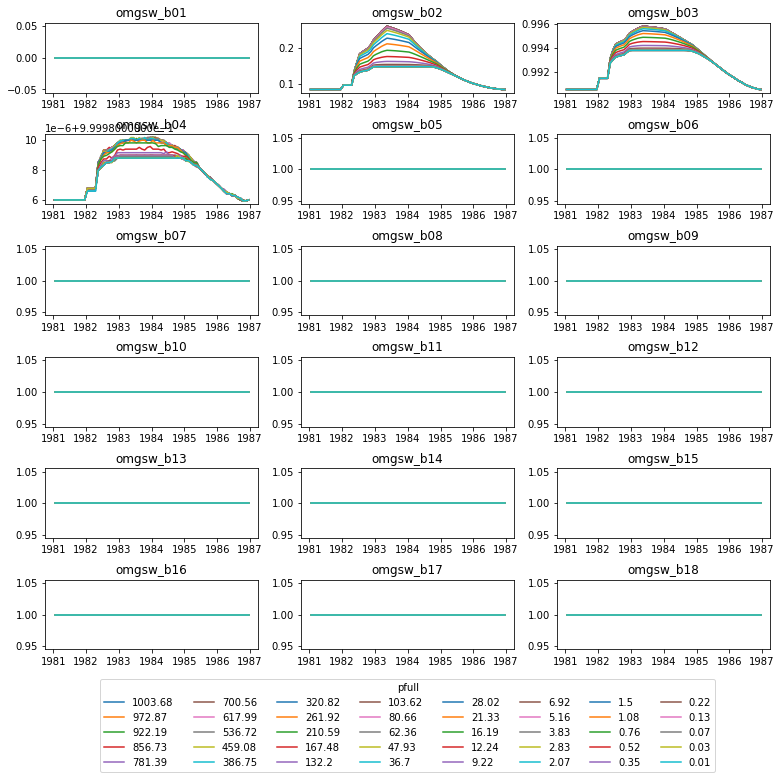

In [13]:
period = slice('1981', '1986')
fig, ax = plt.subplots(6,3, figsize=(13,15))

for a, v in zip(ax.flatten(), f):
    lat_mean = f[v].sel(time=period).mean('lat')
    for lev in lat_mean.pfull.values:
        a.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
                lat_mean.sel(pfull=lev))
    a.set_title(v)
    
fig.subplots_adjust(bottom=0.3, hspace=0.6, wspace=0.2)

ax.flatten()[-2].legend(lat_mean.pfull.values, 
                        title='pfull', loc='upper center', 
                        bbox_to_anchor=(0.5, -0.35), ncol=8);

In [14]:
f = xr.open_dataset(f'{path}INPUT/asmsw_data.nc')

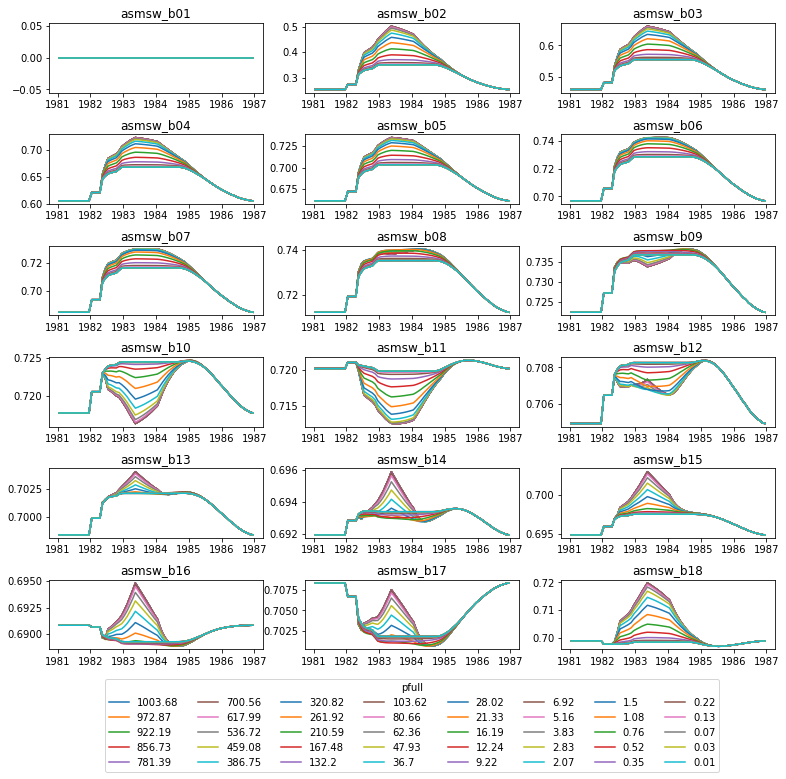

In [15]:
period = slice('1981', '1986')
fig, ax = plt.subplots(6,3, figsize=(13,15))

for a, v in zip(ax.flatten(), f):
    lat_mean = f[v].sel(time=period).mean('lat')
    for lev in lat_mean.pfull.values:
        a.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
                lat_mean.sel(pfull=lev))
    a.set_title(v)
    
fig.subplots_adjust(bottom=0.3, hspace=0.6, wspace=0.2)

ax.flatten()[-2].legend(lat_mean.pfull.values, 
                        title='pfull', loc='upper center', 
                        bbox_to_anchor=(0.5, -0.35), ncol=8);

**So it looks like the volcanic forcing doesn't change after the year 2000 anyway. In fact, every value after 1999-12 is just a replica of the 1999-12 data:**

In [19]:
f = xr.open_dataset(f'{path}INPUT/extsw_data.nc')
(f.sel(time='1999-12').squeeze() == f.sel(time=slice('2000',None))).all()

<xarray.Dataset>
Dimensions:    ()
Data variables: (12/18)
    extsw_b01  bool True
    extsw_b02  bool True
    extsw_b03  bool True
    extsw_b04  bool True
    extsw_b05  bool True
    extsw_b06  bool True
    ...         ...
    extsw_b13  bool True
    extsw_b14  bool True
    extsw_b15  bool True
    extsw_b16  bool True
    extsw_b17  bool True
    extsw_b18  bool True

In [20]:
f = xr.open_dataset(f'{path}INPUT/omgsw_data.nc')
(f.sel(time='1999-12').squeeze() == f.sel(time=slice('2000',None))).all()

<xarray.Dataset>
Dimensions:    ()
Data variables: (12/18)
    omgsw_b01  bool True
    omgsw_b02  bool True
    omgsw_b03  bool True
    omgsw_b04  bool True
    omgsw_b05  bool True
    omgsw_b06  bool True
    ...         ...
    omgsw_b13  bool True
    omgsw_b14  bool True
    omgsw_b15  bool True
    omgsw_b16  bool True
    omgsw_b17  bool True
    omgsw_b18  bool True

In [21]:
f = xr.open_dataset(f'{path}INPUT/asmsw_data.nc')
(f.sel(time='1999-12').squeeze() == f.sel(time=slice('2000',None))).all()

<xarray.Dataset>
Dimensions:    ()
Data variables: (12/18)
    asmsw_b01  bool True
    asmsw_b02  bool True
    asmsw_b03  bool True
    asmsw_b04  bool True
    asmsw_b05  bool True
    asmsw_b06  bool True
    ...         ...
    asmsw_b13  bool True
    asmsw_b14  bool True
    asmsw_b15  bool True
    asmsw_b16  bool True
    asmsw_b17  bool True
    asmsw_b18  bool True

### Ozone forcing
Time varying ozone forcing is used for forecasts initialised prior to or during 2004, and 2014 ozone forcing is used for those initialised after 2004. **Why was this done?**

As for the volcanic forcing, having the switch between time varying and fixed forcing based on _initialisation date_ means that the same calendar year can experience different forcing, depending on its lead time. For example, The lead 2 year forecast of 2006 (initialised 2004) will be forced with 2006 ozone forcing, but the lead 1 forecast of 2006 (initialised 2005) will be forced with 2014 forcing. This makes the forecasts difficult to interpret and, perhaps more importantly, baseline.

In [4]:
f = xr.open_dataset(f'{path}INPUT/CM3_CMIP6_1950-2014_O3.nc')

Text(0.5, 1.0, 'pfull=1.5')

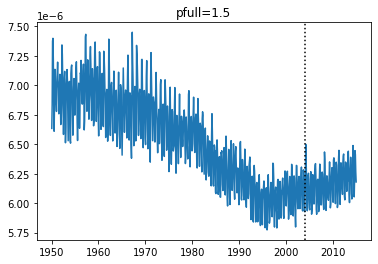

In [5]:
oz_gbl = f['ozone'].isel(pfull=10).mean(['lat','lon'])

plt.plot([np.datetime64(t.strftime()) for t in oz_gbl.time.values],
         oz_gbl)
ylims = plt.gca().get_ylim()
plt.plot([np.datetime64('2004-01-01'),np.datetime64('2004-01-01')], 
         ylims, 'k:')
plt.ylim(ylims)
plt.title(f'pfull={str(oz_gbl.pfull.values)}')

#### How do each of the years after 2004 compare to 2014?

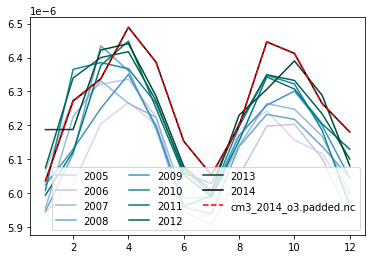

In [6]:
from matplotlib.pyplot import cm
level = 10

years = range(2005, 2014)
colors = cm.PuBuGn(np.linspace(0.2,1,len(years)))
for year, c in zip(years, colors):
    gbl = f['ozone'].isel(pfull=level).sel(time=str(year)).mean(['lat','lon'])
    plt.plot(range(1,13), gbl, label=str(year), color=c)
gbl = f['ozone'].isel(pfull=level).sel(time='2014').mean(['lat','lon'])
plt.plot(range(1,13), gbl, label='2014', color='k')

f2 = xr.open_dataset(f'{path}INPUT/cm3_2014_o3.padded.nc')
gbl_fixed = f2['ozone'].isel(pfull=level).sel(time='2014').mean(['lat','lon'])
plt.plot(range(1,13), gbl_fixed, label='cm3_2014_o3.padded.nc', color='r', linestyle='--')

plt.legend(ncol=3)

In [15]:
f.sel(time=slice('2013','2016')).time

<xarray.DataArray 'time' (time: 24)>
array([cftime.DatetimeNoLeap(2013, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2013-01-16 12:00:00 ... 2014-12-16 12:00:00
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

In [9]:
f2.time

<xarray.DataArray 'time' (time: 14)>
array([cftime.DatetimeNoLeap(2013, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2013-12-16 12:00:00 ... 2015-01-16 12:00:00
Attributes:
    long_name:      time
    standard_name:  time
    axis:           T

### Solar forcing
The namelist suggest that fixed 1990 solar forcing is applied for all forecasts. There is a file `lean_solar_spectral_data.dat` in the /INPUT directory containing monthly values of something from 1882. I have no idea whether it is used.

### Radiative gas forcing
I'm assuming that these are taken from the `*_gblannualdata` files (`./resources/scratch.ux06.ds0092.CAFE.forecasts.f6.WIP.c5-d60-pX-f6-19900501.MOM.INPUT.*_gblannualdata`) and are time varying regardless of forecast initialisation date. **Can Matt provide an indication of what these are - how are obs + scenarios combined to get these files?**

(1800.0, 2165.5)

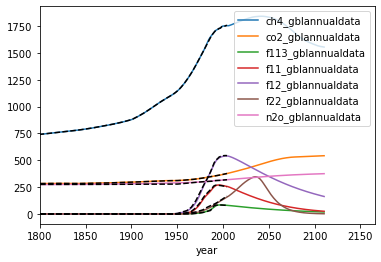

In [27]:
files = ['ch4_gblannualdata', 'co2_gblannualdata', 'f113_gblannualdata', 'f11_gblannualdata', 
         'f12_gblannualdata', 'f22_gblannualdata', 'n2o_gblannualdata']
for file in files:
    f = read_gblannualdata(f'{path}INPUT/{file}')
    f.plot()
plt.legend(files)

for file in files:
    f = read_gblannualdata(f'./resources/g.data.v19.mtc599.ao_am2.aug18a.INPUT.{file}')
    f.plot(linestyle='--', color='k')
plt.legend(files)
plt.xlim(1800, None)

Regarding the aco2_file specified in the namelist (I think associated with the model bgc component), `INPUT/co2_obs.padded.nc` is used if the forecast is initialised after 2007, otherwise `INPUT/co2_obs.nc` is used. Both files are spatially constant and indentically in their overlapping period. Therefore the if statement here appears to be redundant.

In [28]:
f1 = xr.open_dataset(f'{path}INPUT/co2_obs.nc', decode_times=False)
f2 = xr.open_dataset(f'{path}INPUT/co2_obs.padded.nc', decode_times=False)

In [29]:
gbl1 = f1['co2'].mean(['grid_x_T','grid_y_T'])
gbl2 = f2['co2'].mean(['grid_x_T','grid_y_T'])

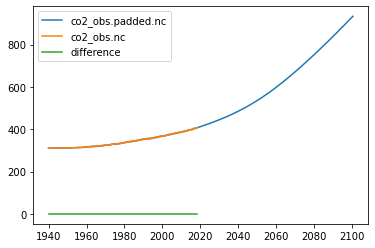

In [30]:
plt.plot(gbl2.time+1700, gbl2, label='co2_obs.padded.nc')
plt.plot(gbl1.time+1700, gbl1, label='co2_obs.nc')
diff = gbl2 - gbl1
plt.plot(diff.time+1700, diff, label='difference')
plt.legend()

**What is perhaps concerning is that the future forcing specified in `co2_obs.padded.nc` appears to be different than that specified `co2_gblannualdata`. These files start to deviate around 2020**

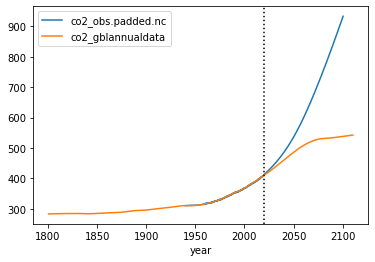

In [31]:
plt.plot(gbl2.time+1700, gbl2, label='co2_obs.padded.nc')
f = read_gblannualdata(f'{path}INPUT/co2_gblannualdata')
f.plot(label='co2_gblannualdata')

ylims = plt.gca().get_ylim()
plt.plot([2020,2020], 
         ylims, 'k:')
plt.ylim(ylims)

plt.legend()

## So what does this _actually_ mean?

**Aerosol forcing**
> If initialised during or before 1999, we use the forcing climatologies corresponding to the decade of initialisation\
If initialised after 1999, we use the forcing climatologies for the 2000s \
<span style="color:red">This behaviour cannot be replicated using a single historical run since the same calendar year can experience different forcing, depending on its lead time. For example, the lead 2-year forecast of 2001 (initialised 1999) will be forced with **1990s** forcing, but the lead 1 forecast of the same year (initialised 2000) will be forced with **2000s** forcing.</span>

**Volcanic forcing**
> We use time varying volcanic forcing up until 1999-12, and then 1999-12 levels from 2000-01 onwards. (Because the forcing files don't actually change after 1999-12, the switch to 2008 forcing in our forecast scripts for initialisation dates after 2000 actually does nothing, other than to allow forecasts to be run beyond the maximum time of the forcing files, 2010-12).

**Ozone forcing**
> If initialised during or before 2004, we use time varying monthly (CMIP6) ozone forcing
If initialised after 2004, we use the 2014 ozone forcing \
<span style="color:red">This behaviour cannot be replicated using a single historical run since the same calendar year can experience different forcing, depending on its lead time. For example, the lead 2-year forecast of 2006 (initialised 2004) will be forced with **2006** forcing, but the lead 1 forecast of the same year (initialised 2005) will be forced with **2014** forcing.</span>

**Solar forcing**
> The namelist suggest that fixed 1990 solar forcing is applied for all forecasts. \
<span style="color:red">Was this intended.</span>

**Radiative gas forcing**
> We use time varying observed and projected radiative gas forcing out to 2110. \
<span style="color:red">It's not clear to me what scenario is used, or when the switch is made from observations to projections. It looks like `co2_gblannualdata` uses RCP4.5 and `co2_obs.padded.nc` uses RCP 8.5. Why are these different?.</span>

# Are we consistent with CMIP6?
The CMIP6 docs (https://doi.org/10.5194/gmd-9-1937-2016) request historical forcings are based as far as possible on observations and cover the period 1850–2014:
>The historical forcings are based as far as possible on observations and cover the period 1850–2014. These include:\
– emissions of short-lived species and long-lived greenhouse gases (GHGs),\
– GHG concentrations,\
– global gridded land-use forcing data sets,\
– solar forcing,
– stratospheric aerosol data set (volcanoes),\
– AMIP sea surface temperatures (SSTs) and sea ice concentrations (SICs),\
– for simulations with prescribed aerosols, a new approach to prescribe aerosols in terms of optical properties and fractional change in cloud droplet effective radius to provide a more consistent representation of aerosol forcing, and\
– for models without ozone chemistry, time-varying gridded ozone concentrations and nitrogen deposition.

Our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP6 specifications...

We appear to be using the CMIP6 **ozone forcing** data. But, I'm not sure we actually use it in a way consistent with the CMIP6 DCPP protocols (https://doi.org/10.5194/gmd-9-3751-2016) which states (Appendix A):
> The A1 hindcast experiment parallels the corresponding CMIP5 decadal prediction experiment in using the same specified forcing as is used for the CMIP6 historical climate simulations. This forcing is also used for the historical simulations of experiment A2. For forecasts which extend beyond the period for which historical forcing is specified, the “medium” SSP2-4.5 forcing of ScenarioMIP (O’Neill et al., 2016) is used.

and, from Table A1:

> Prescribed CMIP6 historical values of atmospheric composition and/or emissions (and other conditions including volcanic aerosols). Future forcing as the SSP2-4.5 scenario.

<span style="color:red">Does SSP2-4.5 provide ozone forcing?</span> If so, our switch to 2014 forcing for forecasts initialised after 2004 goes against DCPP requests. If not, it's not clear to me what the DCPP expects us to do for future ozone.

It's not clear to me whether or not we are using observed **raditive gas forcing** from CMIP6, but my hunch is that the `*_gblannualdata` files transition from observations to scenarios in 2000. <span style="color:red">If I'm right, I guess these are more like CMIP3 forcing files? Can Matt confirm?</span>

# Are we consistent with CMIP5?
The CMIP5 docs (https://pcmdi.llnl.gov/mips/cmip5/docs/Taylor_CMIP5_design.pdf) request historical forcings are based as far as possible on observations and cover the period 1850–2005:
> - All forcings should be included as observed values for past dates, with prescribed concentrations of well-mixed GHGs. The details should be the same as used in the CMIP5 historical (20th century) runs (see Table 3), with the same flexibility on the treatment of ozone and aerosol and the same specified observational datasets. Note that with the exception of experiment 1.3, aerosols from observed volcanic eruptions should be included in all of the simulations.

where Table 3 gives:

> for CMIP5 historical (1850 - at least 2005), impose changing conditions (consistent with observations), which may include atmospheric composition (including CO2), due to both anthropogenic and volcanic influences; solar forcing; emissions or concentrations of short-lived species and natural and anthropogenic aerosols or their precursors; land use)

Also:
> - For future dates, the RCP4.5 scenario should be used if possible. Specification of reactive species and aerosols will follow those used in the long-term projection runs (see Table 4). With the exception of experiment 1.4, assume that there are no volcanic eruptions in the future (i.e., after year 2009).
> - Note the treatment of volcanic aerosol: observed values should be used for past dates, as per CMIP5, but values to be used after 2005 should be specified based on the assumption of no further volcanic eruptions. The model runs are thus configured to predict what will happen to climate, relative to the observed past, if no major eruptions take place, which is a possible outcome for a thirty year period.

But as above, our,
 - **Aerosol climatology** data is just replicated from the 2000s onwards,
 - **Volcanic forcing** data is just replicated from 1999-12 onwards,
 - **Solar forcing** doesn't change
 
so these aren't consistent with CMIP5 specifications either...

# Are we consistent with CMIP3?

My guess is that our **Aerosol climatology forcing**, **Volcanic forcing**, **Solar forcing** and **Radiative gas forcing** data are all mostly consistent with CMIP3 era - this is when most of these forcing files transition to fixed / projected values